In [2]:
#!pip install transformers datasets
#!pip install --upgrade huggingface_hub
#!pip install ipywidgets
#jupyter nbextension enable --py widgetsnbextension

In [53]:
import numpy as np
import pandas as pd
import spacy
import json
from collections import Counter
import torch
import os
from datasets import Dataset
from sklearn.feature_extraction.text import TfidfVectorizer
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, pipeline, EarlyStoppingCallback
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report, confusion_matrix, ConfusionMatrixDisplay


In [2]:
# Disable symlink warning
os.environ["HF_HUB_DISABLE_SYMLINKS_WARNING"] = "1"

In [3]:
with open('dataset/dataset.json', 'r') as f:
    dataset = json.load(f)    

In [4]:
# Load spaCy's English model
nlp = spacy.load('en_core_web_sm')

## Cleaning Training Data
#### Function to extract the text from a record.

In [5]:
def extract_text(record):
    for field in ['description', 'content', 'text']:
        if field in record and record[field] is not None and str(record[field]).strip() != "":
            return str(record[field]).strip()
    return None

#### Mapping function to clean the label.
##### The target mapping is:
##### 0: National Maritime Museum
##### 1: National Railway Museum
##### 2: Royal Botanic Gardens, Kew
##### 3: Royal College of Physicians of London
##### 4: Shakespeare Birthplace Trust

In [6]:
def clean_label(record):
    # Check in possible fields: 'labl', 'label', or 'key'
    for field in ['labl', 'label', 'key']:
        if field in record and record[field] is not None:
            try:
                # If label is numeric already, return it as int.
                return int(record[field])
            except:
                label_str = str(record[field]).strip()
                # Use substring matching to fix common misspellings:
                if "maritime" in label_str.lower():
                    return 0
                elif "railway" in label_str.lower():
                    return 1
                elif "botanic" in label_str.lower():
                    return 2
                elif "physicians" in label_str.lower():
                    return 3
                elif "birthplace" in label_str.lower():
                    return 4
    return None

#### Function to process a list of records (for a given split)

In [7]:
def process_split(records):
    processed = []
    for record in records:
        text = extract_text(record)
        if not text:
            continue  # Skip records with missing text
        label = clean_label(record)
        if label is None:
            continue  # Skip records with unresolvable labels
        processed.append({
            "id": record.get("id"),
            "text": text,
            "label": label
        })
    return pd.DataFrame(processed)

In [8]:
# Process each split using the functions above
train_df = process_split(dataset.get('train', []))
val_df   = process_split(dataset.get('val', []))
test_df  = process_split(dataset.get('test', []))

# Optional -> remove duplicate texts from the training set
train_df = train_df.drop_duplicates(subset=['text'])


In [9]:
print("=== Q1: Data Cleaning Completed ===")
print("Cleaned training set sample:")
train_df


=== Q1: Data Cleaning Completed ===
Cleaned training set sample:


,id,text,label
0,08838524-6d11-729c-39d8-fa4d712b7476,Exhaust steam pipe protector piece fitted belo...,1
1,467eb98e-1866-708e-03cd-9ab9f8a7f4e5,This journal seems to have been kept parallel ...,2
2,b78f8473-e487-b3cb-be65-4f854d97228b,'Remainder Correspondence of the Bibliographic...,2
3,ea15bfc9-9499-e9e2-b3e4-654714a795a5,The particulars of an inquest upon the murder ...,4
4,03556d52-3c1e-f36e-97bd-1a09c87ef949,London Brighton & South Coast Railway official...,1
...,...,...,...
148,246aeb01-6686-57ab-9f4e-3a15f01446e5,535970,3
149,1a81f93b-6256-ff41-2117-a23a1c4d7156,"Philip Stephens. James Bull, late a Clerk in t...",0
150,5911d963-3dae-5839-2443-960930f73aa3,"Deposition by Thomas Jewell, Shipwright. When ...",0
151,cdba4d41-7d2b-e7ea-5b15-77c7b7c1b6e0,The daughters of William Harbord esq. deceased...,4


## Data Exploration
#### Report sample counts and percentage splits

In [10]:
train_count = len(train_df)
val_count   = len(val_df)
test_count  = len(test_df)
total_count = train_count + val_count + test_count

In [11]:
print("Sample counts:")
print(f"  Training:   {train_count}")
print(f"  Validation: {val_count}")
print(f"  Test:       {test_count}")

print("\nPercentage splits:")
print(f"  Training:   {100 * train_count / total_count:.2f}%")
print(f"  Validation: {100 * val_count / total_count:.2f}%")
print(f"  Test:       {100 * test_count / total_count:.2f}%")

Sample counts:
  Training:   153
  Validation: 50
  Test:       50

Percentage splits:
  Training:   60.47%
  Validation: 19.76%
  Test:       19.76%


#### Compute minimum and maximum text lengths (in characters) for each split

In [12]:
def text_length_stats(df, split_name):
    lengths = df['text'].apply(len)
    print(f"\n{split_name} set text length stats:")
    print(f"  Min length: {lengths.min()} characters")
    print(f"  Max length: {lengths.max()} characters")

In [13]:
text_length_stats(train_df, "Training")
text_length_stats(val_df, "Validation")
text_length_stats(test_df, "Test")


Training set text length stats:
  Min length: 6 characters
  Max length: 4263 characters

Validation set text length stats:
  Min length: 154 characters
  Max length: 2794 characters

Test set text length stats:
  Min length: 167 characters
  Max length: 3479 characters


#### Tokenize texts and report the five most frequent tokens in each class.

In [14]:
def text_pipeline_spacy_special(text):
  tokens = []
  doc = nlp(text)
  for t in doc:
    if not t.is_punct and not t.is_space and not t.is_stop: # what we removed: "not t.is_stop and"
      tokens.append(t.text.lower()) # what we changed: t.text instead of t.lemma_
  return tokens

In [15]:
print("\nMost frequent five tokens per class (using the training set):")
for label in sorted(train_df['label'].unique()):
    class_texts = train_df[train_df['label'] == label]['text']
    token_counter = Counter()
    for text in class_texts:
        tokens = text_pipeline_spacy_special(text)
        token_counter.update(tokens)
    most_common = token_counter.most_common(5)
    print(f"  Class {label}: {most_common}")


Most frequent five tokens per class (using the training set):
  Class 0: [('john', 16), ('sir', 11), ('henry', 10), ('enclosure', 10), ('james', 9)]
  Class 1: [('2000', 144), ('7200', 144), ('756', 143), ('gb', 142), ('class', 28)]
  Class 2: [('letter', 19), ('papers', 14), ('letters', 11), ('ridley', 9), ('journal', 8)]
  Class 3: [('seal', 25), ('common', 21), ('mr.', 17), ('college', 17), ('fellow', 16)]
  Class 4: [('mr.', 18), ('work', 15), ('hall', 12), ('william', 12), ('mending', 12)]


## Evaluating Prompt Templates

In [16]:
def load_predictions(file_path):
    """
    Loads prediction outputs from a prompt template file.
    Each record is expected to have an "id" and a "next_token" field.
    If next_token cannot be parsed as an integer in [0,1,2,3,4],
    it is treated as an invalid prediction and assigned class 5.
    """
    with open(file_path, 'r') as f:
        predictions = json.load(f)
    pred_dict = {}
    for pred in predictions:
        pred_raw = str(pred.get("next_token", "")).strip()
        try:
            pred_int = int(pred_raw)
            if pred_int not in [0, 1, 2, 3, 4]:
                pred_int = 5  # Invalid numeric value
        except:
            pred_int = 5  # Cannot convert: treat as invalid
        pred_dict[pred.get("id")] = pred_int
    return pred_dict

In [17]:
# Load predictions from each prompt template file.
preds_template1 = load_predictions('prompts/llm_prompt_template_1.json')
preds_template2 = load_predictions('prompts/llm_prompt_template_2.json')
preds_template3 = load_predictions('prompts/llm_prompt_template_3.json')

In [19]:
def evaluate_predictions(pred_dict, ground_df):
    """
    Matches predictions with ground truth based on record IDs.
    If a record in the ground truth does not have a prediction,
    it is assigned the invalid class 5.
    Computes and returns overall accuracy, macro precision,
    macro recall, macro F1, and a detailed classification report.
    """
    ground_df = ground_df.copy()
    ground_df['pred'] = ground_df['id'].apply(lambda x: pred_dict.get(x, 5))
    y_true = ground_df['label']
    y_pred = ground_df['pred']
    acc = accuracy_score(y_true, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, labels=[0,1,2,3,4,5], average='macro', zero_division=0
    )
    report = classification_report(y_true, y_pred, labels=[0,1,2,3,4,5], zero_division=0)
    return acc, precision, recall, f1, report

In [20]:
# Evaluate predictions for each prompt template
acc1, prec1, rec1, f1_1, report1 = evaluate_predictions(preds_template1, train_df)
acc2, prec2, rec2, f1_2, report2 = evaluate_predictions(preds_template2, train_df)
acc3, prec3, rec3, f1_3, report3 = evaluate_predictions(preds_template3, train_df)

In [21]:
# Print out the evaluation results
print("=== Prompt Template 1 Evaluation ===")
print(report1)
print(f"Accuracy: {acc1:.4f}, Macro Precision: {prec1:.4f}, Macro Recall: {rec1:.4f}, Macro F1: {f1_1:.4f}\n")

print("=== Prompt Template 2 Evaluation ===")
print(report2)
print(f"Accuracy: {acc2:.4f}, Macro Precision: {prec2:.4f}, Macro Recall: {rec2:.4f}, Macro F1: {f1_2:.4f}\n")

print("=== Prompt Template 3 Evaluation ===")
print(report3)
print(f"Accuracy: {acc3:.4f}, Macro Precision: {prec3:.4f}, Macro Recall: {rec3:.4f}, Macro F1: {f1_3:.4f}\n")

=== Prompt Template 1 Evaluation ===
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      29.0
           1       0.00      0.00      0.00      34.0
           2       0.00      0.00      0.00      28.0
           3       0.00      0.00      0.00      32.0
           4       0.00      0.00      0.00      30.0
           5       0.00      0.00      0.00       0.0

    accuracy                           0.00     153.0
   macro avg       0.00      0.00      0.00     153.0
weighted avg       0.00      0.00      0.00     153.0

Accuracy: 0.0000, Macro Precision: 0.0000, Macro Recall: 0.0000, Macro F1: 0.0000

=== Prompt Template 2 Evaluation ===
              precision    recall  f1-score   support

           0       0.66      0.86      0.75        29
           1       0.94      0.85      0.89        34
           2       0.88      0.79      0.83        28
           3       0.64      0.88      0.74        32
           4       0.83      

## Fine-tuning a transformer

In [22]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

In [23]:
def tokenize_function(examples):
    return tokenizer(examples["text"], truncation=True, padding="max_length", max_length=128)


In [24]:
# Convert your train/val dataframes into a Dataset object (from Hugging Face "datasets")
train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)

# Map the tokenization function
train_dataset = train_dataset.map(tokenize_function, batched=True)
val_dataset   = val_dataset.map(tokenize_function, batched=True)

# Set the format so that PyTorch can handle it easily
train_dataset.set_format("torch", columns=["input_ids", "attention_mask", "label"])
val_dataset.set_format("torch", columns=["input_ids", "attention_mask", "label"])

Map:   0%|          | 0/153 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

In [25]:
# LOad the Model
model = AutoModelForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=5  # We have 5 classes
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [26]:
#Defining evaluation metrics
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)

    # Overall metrics
    accuracy = accuracy_score(labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, predictions, average='macro', zero_division=0
    )
    return {
        "accuracy": accuracy,
        "macro_precision": precision,
        "macro_recall": recall,
        "macro_f1": f1
    }

In [27]:
# Training args
training_args = TrainingArguments(
    output_dir="./bert_finetune",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    num_train_epochs=8,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    learning_rate=5e-5,
    logging_steps=50,
    load_best_model_at_end=False  
)

C:\Users\ASUS\anaconda3\lib\site-packages\transformers\training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [28]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Macro Precision,Macro Recall,Macro F1
1,No log,1.754330,0.200000,0.093636,0.221154,0.129697
2,No log,1.685033,0.280000,0.208791,0.295455,0.242424
3,1.104300,2.473374,0.240000,0.254545,0.238636,0.243158
4,1.104300,2.999472,0.240000,0.191453,0.225000,0.206863
5,0.214500,3.944993,0.220000,0.201818,0.206818,0.204040
6,0.214500,4.355500,0.240000,0.208333,0.225000,0.216304
7,0.214500,4.523464,0.220000,0.183333,0.200000,0.191304
8,0.021700,4.560045,0.220000,0.183333,0.200000,0.191304


TrainOutput(global_step=160, training_loss=0.41969204377382996, metrics={'train_runtime': 442.6528, 'train_samples_per_second': 2.765, 'train_steps_per_second': 0.361, 'total_flos': 80514151593984.0, 'train_loss': 0.41969204377382996, 'epoch': 8.0})

In [29]:
eval_results = trainer.evaluate()
print(eval_results)

{'eval_loss': 4.560044765472412, 'eval_accuracy': 0.22, 'eval_macro_precision': 0.18333333333333332, 'eval_macro_recall': 0.2, 'eval_macro_f1': 0.19130434782608696, 'eval_runtime': 4.188, 'eval_samples_per_second': 11.939, 'eval_steps_per_second': 1.671, 'epoch': 8.0}


In [30]:
predictions, labels, _ = trainer.predict(val_dataset)
preds = np.argmax(predictions, axis=1)

from sklearn.metrics import classification_report
print(classification_report(labels, preds, labels=[0,1,2,3,4]))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00         8
           1       0.00      0.00      0.00        13
           2       0.92      1.00      0.96        11
           3       0.00      0.00      0.00        10
           4       0.00      0.00      0.00         8

    accuracy                           0.22        50
   macro avg       0.18      0.20      0.19        50
weighted avg       0.20      0.22      0.21        50



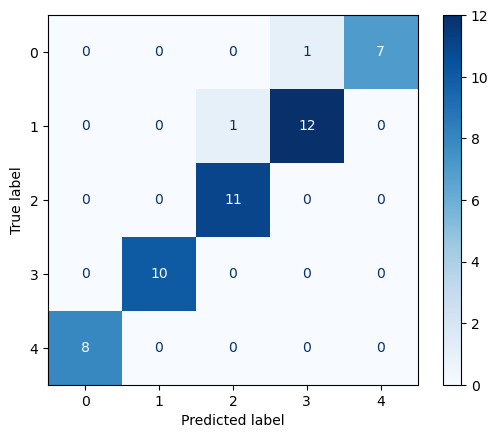

In [31]:
#Confusion Matrix
preds, true_labels, _ = trainer.predict(val_dataset)
preds = np.argmax(preds, axis=1)

cm = confusion_matrix(true_labels, preds, labels=[0,1,2,3,4])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1,2,3,4])
disp.plot(cmap="Blues")

In [33]:
#val_df.to_csv('val_data_with_label.csv', index=False)

In [ ]:
val_dataset

In [ ]:
preds

### Evaluating the best models

In [37]:
def batch_tokenize_function(examples, tokenizer):
    return tokenizer(
        examples["text"],
        truncation=True,
        padding="max_length",
        max_length=128
    )

In [55]:
def train_and_evaluate_model(base_model_name, train_df, val_df, output_dir):
    """
    Fine-tunes a given base model on the training set, evaluates on the validation set,
    and returns the final Trainer object plus classification metrics.
    """

    # 1. Load tokenizer
    tokenizer = AutoTokenizer.from_pretrained(base_model_name)

    # 2. Convert pandas DF to Dataset
    train_dataset = Dataset.from_pandas(train_df)
    val_dataset   = Dataset.from_pandas(val_df)

    # 3. Tokenize
    def tokenize_batch(examples):
        return batch_tokenize_function(examples, tokenizer)

    train_dataset = train_dataset.map(tokenize_batch, batched=True)
    val_dataset   = val_dataset.map(tokenize_batch, batched=True)

    # 4. Set format for PyTorch
    train_dataset.set_format("torch", columns=["input_ids", "attention_mask", "label"])
    val_dataset.set_format("torch", columns=["input_ids", "attention_mask", "label"])

    # 5. Load the model
    model = AutoModelForSequenceClassification.from_pretrained(
        base_model_name,
        num_labels=5
    )

    # 6. Set up training arguments
    training_args = TrainingArguments(
        output_dir=output_dir,
        evaluation_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,   
        metric_for_best_model="macro_f1",  # we want the best model by macro-F1
        greater_is_better=True,           # macro-F1: bigger is better
        num_train_epochs=8,
        per_device_train_batch_size=8,
        per_device_eval_batch_size=8,
        learning_rate=5e-5,
        logging_steps=50,
        save_total_limit=1  # keep only the best checkpoint
    )

    # Early stopping
    early_stopping = EarlyStoppingCallback(
    early_stopping_patience=1,  # how many epochs of no improvement to allow
    early_stopping_threshold=0.0
    )

    # 7. Initialize the Trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        compute_metrics=compute_metrics,
        callbacks=[early_stopping]
    )

    # 8. Train
    trainer.train()


    # 9. Evaluate
    metrics = trainer.evaluate()
    # Also do a classification report for per-class metrics
    predictions, labels, _ = trainer.predict(val_dataset)
    preds = np.argmax(predictions, axis=1)

    class_report = classification_report(labels, preds, labels=[0,1,2,3,4], zero_division=0)

    return trainer, metrics, class_report


In [39]:
base_models = [
    "bert-base-uncased",
    "roberta-base",
    "distilbert-base-uncased",
    "microsoft/BiomedNLP-BiomedBERT-base-uncased-abstract"
]

results = {}

for base_model_name in base_models:
    print(f"\n=== TRAINING MODEL: {base_model_name} ===")
    output_dir = f"./{base_model_name.replace('/', '_')}_results"

    trainer, metrics, class_report = train_and_evaluate_model(
        base_model_name,
        train_df,
        val_df,
        output_dir
    )

    print("Validation Metrics:", metrics)
    print("Classification Report:\n", class_report)

    results[base_model_name] = {
        "metrics": metrics,
        "report": class_report
    }


=== TRAINING MODEL: bert-base-uncased ===


Map:   0%|          | 0/153 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\ASUS\anaconda3\lib\site-packages\transformers\training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,Macro Precision,Macro Recall,Macro F1
1,No log,1.812083,0.300000,0.199301,0.320455,0.227807
2,No log,2.015487,0.280000,0.256667,0.275000,0.264320
3,1.092000,2.248708,0.220000,0.157143,0.200000,0.176000
4,1.092000,2.895886,0.240000,0.222222,0.225000,0.223529
5,0.197900,3.606027,0.240000,0.194231,0.225000,0.208333
6,0.197900,3.919049,0.240000,0.191453,0.225000,0.206863
7,0.197900,4.061760,0.240000,0.194231,0.225000,0.208333
8,0.021800,4.141245,0.240000,0.194231,0.225000,0.208333


Validation Metrics: {'eval_loss': 2.0154874324798584, 'eval_accuracy': 0.28, 'eval_macro_precision': 0.25666666666666665, 'eval_macro_recall': 0.275, 'eval_macro_f1': 0.26432022084196, 'eval_runtime': 4.273, 'eval_samples_per_second': 11.701, 'eval_steps_per_second': 1.638, 'epoch': 8.0}
Classification Report:
               precision    recall  f1-score   support

           0       0.17      0.12      0.14         8
           1       0.00      0.00      0.00        13
           2       0.92      1.00      0.96        11
           3       0.00      0.00      0.00        10
           4       0.20      0.25      0.22         8

    accuracy                           0.28        50
   macro avg       0.26      0.28      0.26        50
weighted avg       0.26      0.28      0.27        50


=== TRAINING MODEL: roberta-base ===


Map:   0%|          | 0/153 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\ASUS\anaconda3\lib\site-packages\transformers\training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,Macro Precision,Macro Recall,Macro F1
1,No log,1.626821,0.020000,0.013333,0.015385,0.014286
2,No log,2.386335,0.180000,0.234641,0.171678,0.191373
3,1.109400,2.955378,0.200000,0.228571,0.188636,0.206667
4,1.109400,4.064779,0.240000,0.254545,0.238636,0.243158
5,0.116800,5.008663,0.240000,0.216667,0.225000,0.219876
6,0.116800,5.085359,0.240000,0.208333,0.225000,0.216304
7,0.116800,5.136969,0.240000,0.208333,0.225000,0.216304
8,0.012700,5.188799,0.240000,0.208333,0.225000,0.216304


Validation Metrics: {'eval_loss': 4.064778804779053, 'eval_accuracy': 0.24, 'eval_macro_precision': 0.2545454545454545, 'eval_macro_recall': 0.23863636363636367, 'eval_macro_f1': 0.2431578947368421, 'eval_runtime': 4.2819, 'eval_samples_per_second': 11.677, 'eval_steps_per_second': 1.635, 'epoch': 8.0}
Classification Report:
               precision    recall  f1-score   support

           0       0.27      0.38      0.32         8
           1       0.00      0.00      0.00        13
           2       1.00      0.82      0.90        11
           3       0.00      0.00      0.00        10
           4       0.00      0.00      0.00         8

    accuracy                           0.24        50
   macro avg       0.25      0.24      0.24        50
weighted avg       0.26      0.24      0.25        50


=== TRAINING MODEL: distilbert-base-uncased ===


Map:   0%|          | 0/153 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\ASUS\anaconda3\lib\site-packages\transformers\training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,Macro Precision,Macro Recall,Macro F1
1,No log,1.766495,0.060000,0.400000,0.061364,0.105983
2,No log,2.072623,0.200000,0.222222,0.188636,0.203529
3,1.144500,2.616886,0.240000,0.222222,0.225000,0.223529
4,1.144500,3.176244,0.220000,0.200000,0.200000,0.200000
5,0.174100,3.612104,0.220000,0.200000,0.200000,0.200000
6,0.174100,3.833780,0.220000,0.200000,0.200000,0.200000
7,0.174100,3.963375,0.220000,0.200000,0.200000,0.200000
8,0.029600,4.005792,0.220000,0.200000,0.200000,0.200000


Validation Metrics: {'eval_loss': 2.6168863773345947, 'eval_accuracy': 0.24, 'eval_macro_precision': 0.22222222222222224, 'eval_macro_recall': 0.225, 'eval_macro_f1': 0.2235294117647059, 'eval_runtime': 2.144, 'eval_samples_per_second': 23.321, 'eval_steps_per_second': 3.265, 'epoch': 8.0}
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         8
           1       0.00      0.00      0.00        13
           2       1.00      1.00      1.00        11
           3       0.00      0.00      0.00        10
           4       0.11      0.12      0.12         8

    accuracy                           0.24        50
   macro avg       0.22      0.23      0.22        50
weighted avg       0.24      0.24      0.24        50


=== TRAINING MODEL: microsoft/BiomedNLP-BiomedBERT-base-uncased-abstract ===


Map:   0%|          | 0/153 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at microsoft/BiomedNLP-BiomedBERT-base-uncased-abstract and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\ASUS\anaconda3\lib\site-packages\transformers\training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,Macro Precision,Macro Recall,Macro F1
1,No log,1.686404,0.220000,0.156667,0.213636,0.173272
2,No log,1.977210,0.220000,0.260000,0.208042,0.224127
3,1.057900,2.937741,0.180000,0.200000,0.163636,0.180000
4,1.057900,3.790955,0.200000,0.208571,0.188636,0.198095
5,0.106100,4.962036,0.180000,0.228571,0.170455,0.195088
6,0.106100,5.014729,0.200000,0.225000,0.188636,0.205000
7,0.106100,5.097255,0.200000,0.222222,0.188636,0.203529
8,0.012200,5.175414,0.200000,0.222222,0.188636,0.203529


Validation Metrics: {'eval_loss': 1.977210283279419, 'eval_accuracy': 0.22, 'eval_macro_precision': 0.26, 'eval_macro_recall': 0.20804195804195805, 'eval_macro_f1': 0.22412698412698412, 'eval_runtime': 4.191, 'eval_samples_per_second': 11.93, 'eval_steps_per_second': 1.67, 'epoch': 8.0}
Classification Report:
               precision    recall  f1-score   support

           0       0.17      0.25      0.20         8
           1       0.13      0.15      0.14        13
           2       1.00      0.64      0.78        11
           3       0.00      0.00      0.00        10
           4       0.00      0.00      0.00         8

    accuracy                           0.22        50
   macro avg       0.26      0.21      0.22        50
weighted avg       0.28      0.22      0.24        50



In [40]:
train_df["label"].unique()

array([1, 2, 4, 0, 3], dtype=int64)

In [41]:
val_df["label"].unique()

array([1, 3, 4, 2, 0], dtype=int64)

In [42]:
val_df['label'].value_counts()

label
1    13
2    11
3    10
4     8
0     8
Name: count, dtype: int64

In [43]:
train_df['label'].value_counts()

label
1    34
3    32
4    30
0    29
2    28
Name: count, dtype: int64

## Problem with the validation set

##### The labels seem to be not mapped correctly to the content. Map the correct labels to the content

In [44]:
val_df.head(15)

,id,text,label
0,f4737321-5435-fa79-79de-be2467a2ca77,"Notebook of William Fleming, Bedell. MS notebo...",1
1,cc1d9c86-5e83-80c2-d566-dc724c663690,"Class 2-2-6-0, DETAILS FOR BLOW-DOWN Class 2-2...",3
2,528e5290-f8ff-0eb0-325f-0472b9c1a9ef,"Copy letter from I Mayo, 31 Queen Ann Street [...",4
3,bac8d441-4984-861d-5199-b7a97699c728,Mr Abernethy's Surgical Essays delivered MDCCC...,1
4,dd0fff6a-c351-dd46-cd26-e2d5c61e479c,"M.James, Curate. Certifies that John son of Jo...",4
5,44a036a8-95f1-f40e-3bf8-cf930f287edc,The British Railways (Western Region) signalli...,3
6,e8f9d3cf-c81b-39da-f0d0-2ba7739a099e,COMMITTEES. Committee of Reference R.C.P. Repo...,1
7,f4100f36-c185-3e99-be1e-b560a1971342,"Letter from Sir William Hooker. The letter, to...",2
8,4f6b8e53-67e1-344f-35b3-463435f1e8ec,List of men who signed for their money from Ca...,4
9,58e0b5f7-d05e-c9ef-cdbe-d0dbcb9a5417,They Called Him Mad. The file contains a types...,2


#### Changing the mapping of the  validation dataset

In [45]:
# corect mapping dictionary
label_mapping = {0: 4, 1: 3, 3: 1}

# Apply the mapping to val_df
val_df['label'] = val_df['label'].apply(lambda x: label_mapping[x] if x in label_mapping else x)

#  verify the changes
val_df.head(15)

,id,text,label
0,f4737321-5435-fa79-79de-be2467a2ca77,"Notebook of William Fleming, Bedell. MS notebo...",3
1,cc1d9c86-5e83-80c2-d566-dc724c663690,"Class 2-2-6-0, DETAILS FOR BLOW-DOWN Class 2-2...",1
2,528e5290-f8ff-0eb0-325f-0472b9c1a9ef,"Copy letter from I Mayo, 31 Queen Ann Street [...",4
3,bac8d441-4984-861d-5199-b7a97699c728,Mr Abernethy's Surgical Essays delivered MDCCC...,3
4,dd0fff6a-c351-dd46-cd26-e2d5c61e479c,"M.James, Curate. Certifies that John son of Jo...",4
5,44a036a8-95f1-f40e-3bf8-cf930f287edc,The British Railways (Western Region) signalli...,1
6,e8f9d3cf-c81b-39da-f0d0-2ba7739a099e,COMMITTEES. Committee of Reference R.C.P. Repo...,3
7,f4100f36-c185-3e99-be1e-b560a1971342,"Letter from Sir William Hooker. The letter, to...",2
8,4f6b8e53-67e1-344f-35b3-463435f1e8ec,List of men who signed for their money from Ca...,4
9,58e0b5f7-d05e-c9ef-cdbe-d0dbcb9a5417,They Called Him Mad. The file contains a types...,2


#### Retraining the models 

In [46]:
new_results = {}

for base_model_name in base_models:
    print(f"\n=== TRAINING MODEL: {base_model_name} ===")
    output_dir = f"./{base_model_name.replace('/', '_')}_new_results"

    trainer, metrics, class_report = train_and_evaluate_model(
        base_model_name,
        train_df,
        val_df,
        output_dir
    )

    print("Validation Metrics:", metrics)
    print("Classification Report:\n", class_report)

    new_results[base_model_name] = {
        "metrics": metrics,
        "report": class_report
    }


=== TRAINING MODEL: bert-base-uncased ===


Map:   0%|          | 0/153 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\ASUS\anaconda3\lib\site-packages\transformers\training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,Macro Precision,Macro Recall,Macro F1
1,No log,1.135698,0.580000,0.439427,0.467500,0.419656
2,No log,0.897823,0.640000,0.662857,0.537937,0.563956
3,1.079100,0.631099,0.800000,0.753846,0.664615,0.690756
4,1.079100,0.757765,0.780000,0.753846,0.652115,0.679162
5,0.221900,0.759611,0.800000,0.753846,0.664615,0.690756
6,0.221900,0.870279,0.820000,0.769048,0.680000,0.706704
7,0.221900,0.851583,0.840000,0.783333,0.692500,0.724778
8,0.031800,0.876818,0.840000,0.783333,0.692500,0.724778


Validation Metrics: {'eval_loss': 0.8515831232070923, 'eval_accuracy': 0.84, 'eval_macro_precision': 0.7833333333333333, 'eval_macro_recall': 0.6925, 'eval_macro_f1': 0.7247780320366133, 'eval_runtime': 4.426, 'eval_samples_per_second': 11.297, 'eval_steps_per_second': 1.582, 'epoch': 8.0}
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.90      0.95        10
           2       0.92      1.00      0.96        11
           3       1.00      1.00      1.00        13
           4       1.00      0.56      0.72        16

    accuracy                           0.84        50
   macro avg       0.78      0.69      0.72        50
weighted avg       0.98      0.84      0.89        50


=== TRAINING MODEL: roberta-base ===


Map:   0%|          | 0/153 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\ASUS\anaconda3\lib\site-packages\transformers\training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,Macro Precision,Macro Recall,Macro F1
1,No log,1.360527,0.540000,0.416092,0.447115,0.369524
2,No log,0.813799,0.640000,0.662092,0.529371,0.557432
3,1.109400,0.811013,0.740000,0.726263,0.626136,0.633456
4,1.109400,1.305510,0.740000,0.767532,0.626136,0.658307
5,0.116800,1.183998,0.800000,0.736275,0.675000,0.673729
6,0.116800,1.164232,0.780000,0.756667,0.662500,0.672257
7,0.116800,1.084502,0.800000,0.769048,0.675000,0.692988
8,0.012700,1.100683,0.800000,0.769048,0.675000,0.692988


Validation Metrics: {'eval_loss': 1.0845017433166504, 'eval_accuracy': 0.8, 'eval_macro_precision': 0.769047619047619, 'eval_macro_recall': 0.675, 'eval_macro_f1': 0.6929878495095887, 'eval_runtime': 4.192, 'eval_samples_per_second': 11.927, 'eval_steps_per_second': 1.67, 'epoch': 8.0}
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      1.00      1.00        10
           2       0.92      1.00      0.96        11
           3       0.93      1.00      0.96        13
           4       1.00      0.38      0.55        16

    accuracy                           0.80        50
   macro avg       0.77      0.68      0.69        50
weighted avg       0.96      0.80      0.84        50


=== TRAINING MODEL: distilbert-base-uncased ===


Map:   0%|          | 0/153 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\ASUS\anaconda3\lib\site-packages\transformers\training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,Macro Precision,Macro Recall,Macro F1
1,No log,1.250011,0.520000,0.656104,0.448864,0.383877
2,No log,0.836088,0.820000,0.781818,0.676136,0.714476
3,1.144500,0.647074,0.860000,0.800000,0.712500,0.744000
4,1.144500,0.635399,0.840000,0.785714,0.700000,0.725926
5,0.174100,0.669389,0.840000,0.785714,0.700000,0.725926
6,0.174100,0.697533,0.840000,0.785714,0.700000,0.725926
7,0.174100,0.686634,0.840000,0.785714,0.700000,0.725926
8,0.029600,0.707192,0.840000,0.785714,0.700000,0.725926


Validation Metrics: {'eval_loss': 0.6470741033554077, 'eval_accuracy': 0.86, 'eval_macro_precision': 0.8, 'eval_macro_recall': 0.7125, 'eval_macro_f1': 0.744, 'eval_runtime': 2.136, 'eval_samples_per_second': 23.408, 'eval_steps_per_second': 3.277, 'epoch': 8.0}
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      1.00      1.00        10
           2       1.00      1.00      1.00        11
           3       1.00      1.00      1.00        13
           4       1.00      0.56      0.72        16

    accuracy                           0.86        50
   macro avg       0.80      0.71      0.74        50
weighted avg       1.00      0.86      0.91        50


=== TRAINING MODEL: microsoft/BiomedNLP-BiomedBERT-base-uncased-abstract ===


Map:   0%|          | 0/153 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at microsoft/BiomedNLP-BiomedBERT-base-uncased-abstract and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\ASUS\anaconda3\lib\site-packages\transformers\training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,Macro Precision,Macro Recall,Macro F1
1,No log,1.174013,0.580000,0.708333,0.594209,0.568321
2,No log,1.007960,0.600000,0.656970,0.515734,0.541746
3,1.057900,0.899554,0.740000,0.703509,0.626136,0.633409
4,1.057900,1.171991,0.740000,0.693247,0.623252,0.637681
5,0.106100,1.476854,0.740000,0.724370,0.620455,0.646102
6,0.106100,1.337534,0.780000,0.737500,0.651136,0.675977
7,0.106100,1.420865,0.740000,0.729167,0.626136,0.650219
8,0.012200,1.448672,0.740000,0.729167,0.626136,0.650219


Validation Metrics: {'eval_loss': 1.3375343084335327, 'eval_accuracy': 0.78, 'eval_macro_precision': 0.7375, 'eval_macro_recall': 0.6511363636363636, 'eval_macro_f1': 0.6759770114942529, 'eval_runtime': 4.173, 'eval_samples_per_second': 11.982, 'eval_steps_per_second': 1.677, 'epoch': 8.0}
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      1.00      1.00        10
           2       1.00      0.82      0.90        11
           3       0.81      1.00      0.90        13
           4       0.88      0.44      0.58        16

    accuracy                           0.78        50
   macro avg       0.74      0.65      0.68        50
weighted avg       0.91      0.78      0.82        50



In [47]:
train_df['label'].value_counts()

label
1    34
3    32
4    30
0    29
2    28
Name: count, dtype: int64

In [48]:
val_df

,id,text,label
0,f4737321-5435-fa79-79de-be2467a2ca77,"Notebook of William Fleming, Bedell. MS notebo...",3
1,cc1d9c86-5e83-80c2-d566-dc724c663690,"Class 2-2-6-0, DETAILS FOR BLOW-DOWN Class 2-2...",1
2,528e5290-f8ff-0eb0-325f-0472b9c1a9ef,"Copy letter from I Mayo, 31 Queen Ann Street [...",4
3,bac8d441-4984-861d-5199-b7a97699c728,Mr Abernethy's Surgical Essays delivered MDCCC...,3
4,dd0fff6a-c351-dd46-cd26-e2d5c61e479c,"M.James, Curate. Certifies that John son of Jo...",4
5,44a036a8-95f1-f40e-3bf8-cf930f287edc,The British Railways (Western Region) signalli...,1
6,e8f9d3cf-c81b-39da-f0d0-2ba7739a099e,COMMITTEES. Committee of Reference R.C.P. Repo...,3
7,f4100f36-c185-3e99-be1e-b560a1971342,"Letter from Sir William Hooker. The letter, to...",2
8,4f6b8e53-67e1-344f-35b3-463435f1e8ec,List of men who signed for their money from Ca...,4
9,58e0b5f7-d05e-c9ef-cdbe-d0dbcb9a5417,They Called Him Mad. The file contains a types...,2


###  Final evaluation and deployment

In [49]:
trainer.save_model("distilbert-base-uncased")
tokenizer.save_pretrained("distilbert-base-uncased_new_results/checkpoint-60")

('distilbert-base-uncased_new_results/checkpoint-60\\tokenizer_config.json',
 'distilbert-base-uncased_new_results/checkpoint-60\\special_tokens_map.json',
 'distilbert-base-uncased_new_results/checkpoint-60\\vocab.txt',
 'distilbert-base-uncased_new_results/checkpoint-60\\added_tokens.json',
 'distilbert-base-uncased_new_results/checkpoint-60\\tokenizer.json')

In [50]:
# Path to the directory containing your best model checkpoint from Q6
best_model_dir = "distilbert-base-uncased_new_results/checkpoint-60"

# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained(best_model_dir)

# DistilBERT doesn't need token_type_ids, so remove them if present
if "token_type_ids" in tokenizer.model_input_names:
    tokenizer.model_input_names.remove("token_type_ids")


# Create a text-classification pipeline
classifier = pipeline(
    "text-classification",
    model=best_model_dir,
    tokenizer=best_model_dir,   # Use the same tokenizer directory
    truncation=True,
    return_all_scores=False     # By default, returns only the top predicted label
    #top_k=1
)

C:\Users\ASUS\anaconda3\lib\site-packages\transformers\pipelines\text_classification.py:106: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


#### Evaluation on the test set

In [51]:
test_texts = test_df["text"].tolist()
test_labels = test_df["label"].tolist()

preds = []
for txt in test_texts:
    # The pipeline output for each text is typically a list of dicts:
    # e.g. [{"label": "LABEL_2", "score": 0.93}]
    output = classifier(txt)[0]
    # 'output["label"]' might be something like "LABEL_2"
    label_str = output["label"]
    # Convert "LABEL_2" -> integer 2
    predicted_label = int(label_str.replace("LABEL_", ""))
    preds.append(predicted_label)

# Compute metrics
acc = accuracy_score(test_labels, preds)
precision, recall, f1, _ = precision_recall_fscore_support(
    test_labels, preds, average='macro', zero_division=0
)
print(f"Accuracy: {acc:.4f}")
print(f"Macro Precision: {precision:.4f}")
print(f"Macro Recall: {recall:.4f}")
print(f"Macro F1: {f1:.4f}\n")

# Per-class metrics
print("Detailed classification report:")
print(classification_report(test_labels, preds, labels=[0,1,2,3,4]))

Accuracy: 0.7800
Macro Precision: 0.7806
Macro Recall: 0.8252
Macro F1: 0.7905

Detailed classification report:
              precision    recall  f1-score   support

           0       0.83      0.77      0.80        13
           1       0.88      1.00      0.93         7
           2       0.75      0.82      0.78        11
           3       0.67      1.00      0.80         6
           4       0.78      0.54      0.64        13

    accuracy                           0.78        50
   macro avg       0.78      0.83      0.79        50
weighted avg       0.79      0.78      0.77        50



In [52]:
test_df

,id,text,label
0,590c9f84-30c7-4358-07df-8ba9a476e3f1,"John Percy Banks, Willow Green to G[eorge] Jon...",4
1,1b4f0e98-5197-1998-e732-078544c96b36,"This file contains loose photographs, which ha...",2
2,60303ae2-2b99-8861-bce3-b28f33eec1be,Adaptors for grease nipples; lubricator for re...,1
3,fd61a03a-f4f7-7d87-0fc2-1e05e7e80678,John Harrison having invented a machine in the...,0
4,a4e624d6-86e0-3ed2-767c-0abd85c14426,"Original numbered series, 1-4207 A detailed li...",4
5,a140c0c1-eda2-def2-b830-363ba362aa4d,"William Murray, 1st Earl of Mansfield 1705-179...",3
6,ed0cb90b-dfa4-f939-81a7-d03cff99213a,Notes on the subject of the Rumpenheim lilac i...,2
7,bd7c9112-64aa-e15b-66d4-291b6850829a,Contract containing covenants and provisos in ...,0
8,1f9bfeb1-5fee-8a10-c4d0-711c7eb0c083,"[John Roiffey (Roiffy, Roiffee)] (The writer c...",4
9,b4451034-d3b6-5900-60ce-9484a28b88dd,"Diary. This small, bound diary was given to Be...",2
